Há 28 colunas de features anonimizadas para cada um dos quase 300.000 transações de cartão de crédito. A coluna Time registra o tempo entre transações em milissegundos. A coluna Amount o montante transferido. A coluna Class diz a label da transação: 1 para fraude e 0 para transação legítima.

In [12]:
from sklearn.preprocessing import RobustScaler
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

df_cc = spark.read.parquet('spark-warehouse/cc_db').toPandas()

# Escalonamento
df_cc['Amount'] = RobustScaler().fit_transform(df_cc['Amount'].values.reshape(-1, 1))
df_cc['Time'] = RobustScaler().fit_transform(df_cc['Time'].values.reshape(-1, 1))

features = df_cc.columns.to_list()[:-1]
label = ['Class']

In [13]:
df_cc['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Dada a disparidade do número de entradas legítimas em comparação com fraudulentas, faz-se necessário uma etapa de reamostragem antes de tirar conclusões sobre os dados.

In [14]:
import pandas as pd

num_frauds = df_cc['Class'].sum()
df_cc_copy = df_cc.copy().sample(frac = 1)

df_cc_balanced = pd.concat([
    df_cc_copy.loc[df_cc_copy['Class'] == 1],
    df_cc_copy.loc[df_cc_copy['Class'] == 0][:num_frauds]
])

df_cc_balanced = df_cc_balanced.sample(frac = 1)

df_cc_balanced['Class'].value_counts()

0    492
1    492
Name: Class, dtype: int64

Observa-se que todos os V features possuem distribuição centrada em 0, desvios padrões entre [0,33; 2,00] e uma grande amplitude de valores, entre [-138; 121].

In [15]:
df_cc_balanced.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,...,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000
mean,0.015608,-2.390584,1.834562,-3.454837,2.213270,-1.539215,-0.695733,-2.818560,0.325523,-1.293860,...,0.333885,-0.004049,-0.017846,-0.029917,-0.000119,0.029768,0.089681,0.040468,1.029336,0.500000
std,0.568315,5.486503,3.648285,6.244425,3.225919,4.214332,1.774741,5.835340,4.854710,2.312131,...,2.785766,1.169357,1.163329,0.601099,0.669953,0.490178,1.003611,0.443299,2.913000,0.500254
min,-0.992046,-30.552380,-8.603191,-31.103685,-4.359562,-22.105532,-6.877178,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.211770,-7.263482,-2.401108,-0.307413,0.000000
25%,-0.472218,-2.784711,-0.135667,-5.074851,-0.164381,-1.752398,-1.576412,-3.103406,-0.182937,-2.324444,...,-0.184421,-0.556990,-0.243568,-0.386866,-0.321492,-0.277949,-0.064198,-0.060896,-0.283379,0.000000
50%,-0.080716,-0.814240,0.964356,-1.293397,1.237020,-0.359826,-0.652457,-0.656779,0.160967,-0.659519,...,0.131184,-0.012984,-0.029950,0.012475,0.038336,-0.016241,0.055224,0.036521,-0.066723,0.500000
75%,0.552253,0.970038,2.777569,0.460292,4.221217,0.480149,0.089260,0.264434,0.877259,0.156454,...,0.624776,0.553476,0.192666,0.396050,0.376580,0.322613,0.454884,0.219636,1.089779,1.000000
max,1.026786,2.322645,22.057729,3.102064,12.114672,11.095089,6.479192,5.802537,20.007208,6.286358,...,27.202839,8.361985,5.466230,3.640662,2.208209,3.072937,3.052358,4.803481,29.398030,1.000000


Além da grande disparidade de classe, o banco de dados mostra distribuições diferentes em função da classificação em fraude ou não.

[Text(0.5, 1.0, 'Distribuição do montante pago por classificação'),
 Text(0.5, 0, ''),
 [Text(0, 0, 'Legítima'), Text(1, 0, 'Fraudulenta')],
 Text(0, 0.5, 'Montante')]

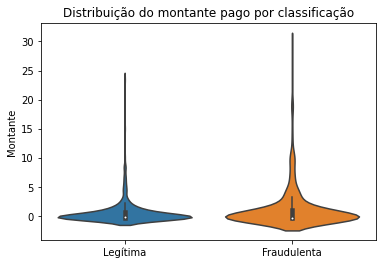

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.violinplot(
    data = df_cc_balanced,
    x = 'Class',
    y = 'Amount',
    scale = 'width'
)\
    .set(
        title = 'Distribuição do montante pago por classificação',
        xlabel = None,
        xticklabels = ['Legítima', 'Fraudulenta'],
        ylabel = 'Montante'
    )

O gráfico de violino mostra que a maior parte dos pagamentos são de pequeno valor. As transações legítimas possuem uma dispersão maior que fraudulentas.

[Text(0.5, 1.0, 'Distribuição temporal por classe'),
 Text(0.5, 0, ''),
 [Text(0, 0, 'Legítima'), Text(1, 0, 'Fraudulenta')],
 Text(0, 0.5, 'Tempo da transação')]

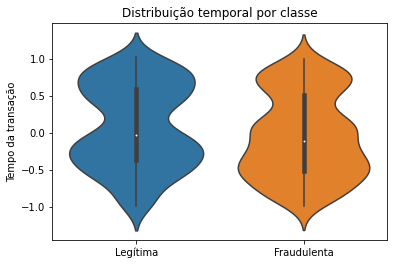

In [17]:
sns.violinplot(
    data = df_cc_balanced,
    x = 'Class',
    y = 'Time'
)\
    .set(
        title = 'Distribuição temporal por classe',
        xlabel = None,
        xticklabels = ['Legítima', 'Fraudulenta'],
        ylabel = 'Tempo da transação'
    )

Esse outro gráfico de violino mostra que ambas as classes tendem a ser bimodais.

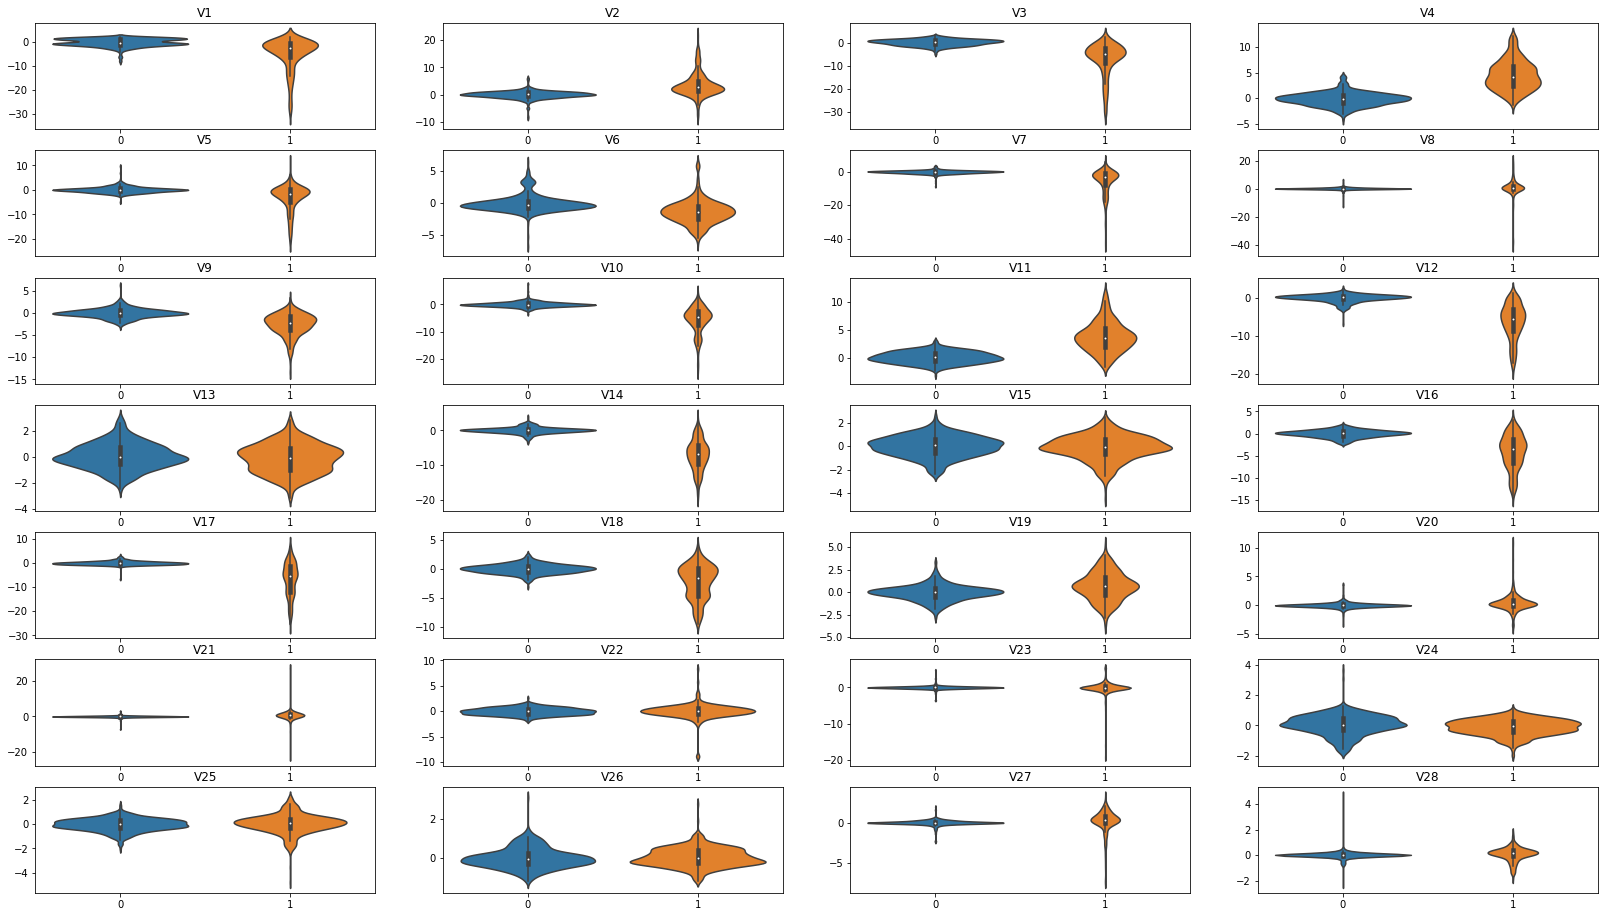

In [18]:
features.remove('Amount')
features.remove('Time')

grid_shape = (7, 4)

features = np.reshape(np.array(features), grid_shape)

fig, axs = plt.subplots(
    nrows = grid_shape[0],
    ncols = grid_shape[1],
    figsize = (4 * grid_shape[0], 4 * grid_shape[1])
)

for i in range(grid_shape[0]):
    for j in range(grid_shape[1]):
        sns.violinplot(
            data = df_cc_balanced,
            x = 'Class',
            y = features[i, j],
            ax = axs[i, j]
        )\
            .set(
                title = features[i, j],
                xlabel = None,
                ylabel = None
            )

Os gráficos de violino deixam claro que há diferenças nas distribuições de label dentre os features. A seguir, se determina quais features são mais importantes para o treinamento do modelo, dessa forma poupando recursos computacionais que seriam desperdiçados em features que pouco contribuiriam para a classificação de clientes.

Text(0.56, 17, 'Correlação de corte')

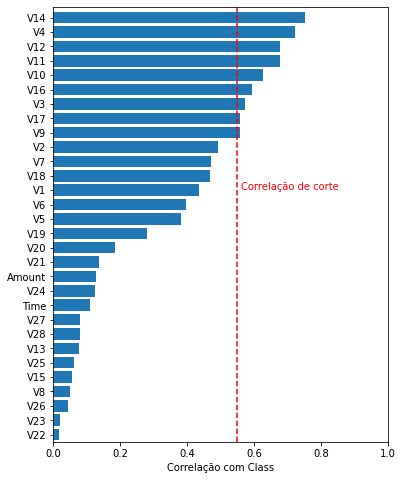

In [19]:
correlation_matrix = df_cc_balanced.corr()
corr_class = correlation_matrix.sort_values('Class', key = lambda x: abs(x))['Class'].iloc[:-1]
corr_class_labels = corr_class.index

fig, ax = plt.subplots(figsize = (6, 8))

ax.barh(
    corr_class_labels,
    abs(corr_class)
)
ax.axvline(0.55, ls = '--', color = 'red')

ax.set_xlabel('Correlação com Class')
ax.set_xlim(xmin = 0, xmax = 1)
ax.set_ylim(ymin = -0.50, ymax = 29.75)
ax.text(
    0.56,
    17,
    'Correlação de corte',
    color = 'red'
)

In [20]:
corr_choice = abs(correlation_matrix.loc['Class']) >= 0.55
training_features = correlation_matrix.loc[corr_choice]['Class'].index.to_list()
training_features

['V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'Class']

Tomando correlações maiores ou iguais à 0,55, escolhe-se os features `V3`, `V4`, `V9`, `V10`, `V11`, `V12`, `V14`, `V16` e `V17`.

In [21]:
db_cc_training = spark.createDataFrame(df_cc_balanced[training_features])
db_cc_training.write.format("parquet").saveAsTable('db_cc_training')

df_cc = spark.createDataFrame(df_cc)
df_cc.write.format('parquet').saveAsTable('db_cc_norm')

22/04/01 17:41:09 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
22/04/01 17:41:41 WARN TaskSetManager: Stage 5 contains a task of very large size (9356 KiB). The maximum recommended task size is 1000 KiB.
22/04/01 17:41:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
